This notebook uses the correlations between the various assay datasets to combine them into a "tmprss2 equivalent" dataset.  The algorithm goes like this:
For each non-TMPRSS2 target:
1. Find the set S of chemicals which were assayed against both TMPRSS2 and the target protein
2. Manually remove outliers from S
3. Perform a linear regression on S, x=TMPRSS2 activites, y=off-target activities.  Outliers are manually removed by inspection.  Collect the slope, and calculate a spearman_r correlation.
4. If spearman_r is high (>.70), use the calculated slope to rescale the target's activity values.
5. Construct combined dataset

Combined Dataset Columns:

* **acvalue_target**: The activity as measured in the original assay, i.e. activity on "target"
* **active_target**: Whether acvalue_target is less than some threshold, defined in data processing notebooks (currently 50)
* **target**: The protein the assay was conducted on (e.g. ST14, TMPRSS2)
* **tmprss2_vs_target_spearman_r**: the spearman_r correlation from algorithm step 3
* **acvalue_scaled_to_tmprss2**: rescaled activity value from algorithm step 4
* **cid**: cid of compound
* **smiles**: smiles of compound


Note 1: spearman-r is used over pearson-r because our data has a skewed distribution.  See this article (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/)

Note 2: the reason I only adjust by slope and not also by intercept is because adjusting by intercept could result in negative activities, which don't make sense.  Fixing intercept at 0 would solve this, but does not seem to be a reasonable assumption.  A near-zero activity on an off-target protein doesn't necessarily mean a near-zero activity on TMPRSS2.  In practice, the correlated off-targets have intercepts near zero, so this is not worth worrying about.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 20)

In [37]:
# collect datasets
TMPRSS2 = pd.read_csv('../dumps/TMPRSS2_processed.csv')

off_targets = {'KLKB1':     pd.read_csv('../dumps/KLKB1_processed.csv'),
               'ST14':      pd.read_csv('../dumps/ST14_processed.csv'),
               'TMPRSS6':   pd.read_csv('../dumps/TMPRSS6_processed.csv'),
               'TMPRSS11D': pd.read_csv('../dumps/TMPRSS11D_processed.csv')}

In [38]:
# calculate overlaps
overlaps = {}
for name, off_target in off_targets.items():
    print(len(off_target))
    overlaps[name] = pd.merge(TMPRSS2, off_target, on=['cid', 'smiles'])
    # make sure 'cid' and 'smiles' are one-to-one
    assert len(overlaps[name]) == len(pd.merge(TMPRSS2, off_target, on=['cid']))

402
255
87
33


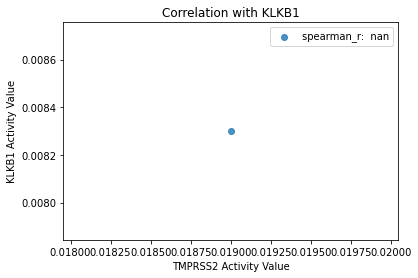

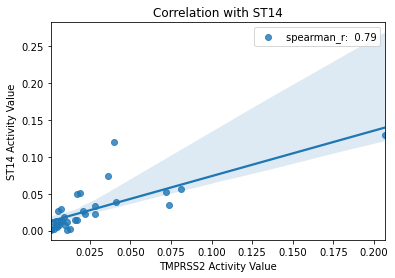

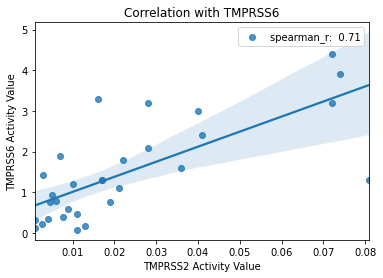

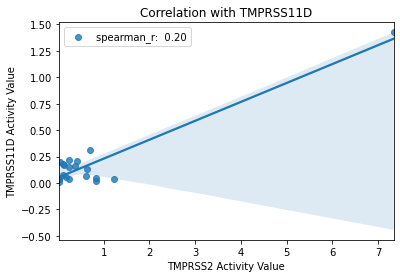

In [39]:
# visualize the overlap correlations
def visualize_overlaps(overlaps, square=False):
    for name, overlap in overlaps.items():
        plt.figure()
        x = overlap['acvalue_x']
        y = overlap['acvalue_y']
        try:
            sns.regplot(x, y, label=f'spearman_r: {spearmanr(x, y)[0]: .2f}')
        except ValueError:
            sns.regplot(x, y, label=f'spearman_r: undefined')
        plt.legend()
        plt.xlabel('TMPRSS2 Activity Value')
        plt.ylabel(f'{name} Activity Value')
        plt.title(f'Correlation with {name}')
        if square:
            plt.axis('square')
visualize_overlaps(overlaps)

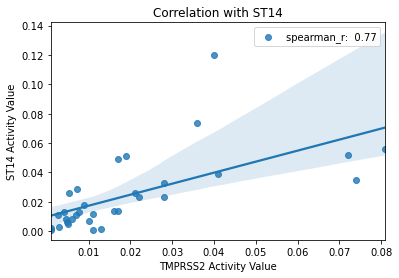

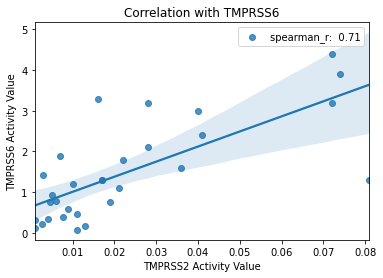

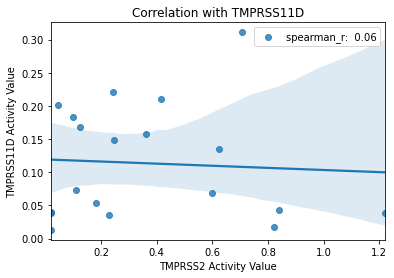

In [40]:
# manually drop outliers by inspection
cleaned_overlaps = {}
cleaned_overlaps['ST14'] = overlaps['ST14'][overlaps['ST14']['acvalue_x'] < .2]
cleaned_overlaps['TMPRSS6'] = overlaps['TMPRSS6'][overlaps['TMPRSS6']['acvalue_x'] < .2]
cleaned_overlaps['TMPRSS11D'] = overlaps['TMPRSS11D'][overlaps['TMPRSS11D']['acvalue_x'] < 7]

visualize_overlaps(cleaned_overlaps)

A summary of the off-targets:
1. KLKB1 has insufficient data to determine correlation
2. ST14 has a strong correlation with TMPRSS2
3. TMPRSS6 has a strong correlation with TMPRSS2
4. TMPRSS11D has no correlation with TMPRSS2

We will thus only bother with scaling ST14 and TMPRSS6.

Before Scaling


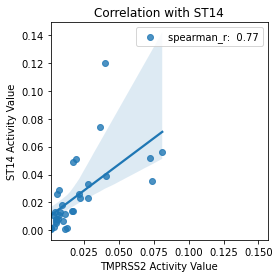

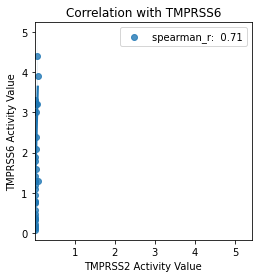

In [41]:
# scaling
print('Before Scaling')
visualize_overlaps({name: cleaned_overlaps[name] for name in ['ST14', 'TMPRSS6']}, square=True)

After Scaling


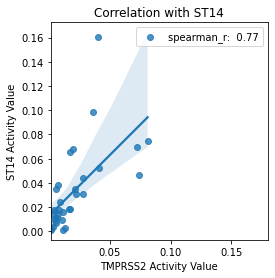

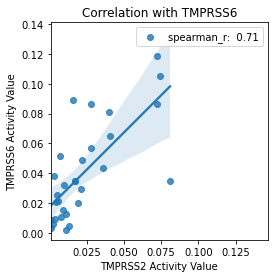

In [42]:
regression_slopes = {'KLKB1': np.nan, 'TMPRSS11D': np.nan}
scaled_overlaps = {}
for name in ['ST14', 'TMPRSS6']:
    overlap = cleaned_overlaps[name].copy()
    x = overlap['acvalue_x']
    y = overlap['acvalue_y']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    regression_slopes[name] = slope
    
    scaled_overlaps[name] = overlap
    scaled_overlaps[name]['acvalue_y'] /= slope
print('After Scaling')
visualize_overlaps(scaled_overlaps, square=True)

In [43]:
# calculate spearman_rs
spearman_rs = {}
cleaned_overlaps
for name, overlap in cleaned_overlaps.items():
    spearman_rs[name] = spearmanr(overlap['acvalue_x'], overlap['acvalue_y'])[0]
spearman_rs['KLKB1'] = np.nan

In [44]:
# Finally, construct the combined dataset
orig_datasets = off_targets
orig_datasets['TMPRSS2'] = TMPRSS2

spearman_rs['TMPRSS2'] = 1
regression_slopes['TMPRSS2'] = 1

reformatted_datasets = []
for target in ['TMPRSS2', 'KLKB1', 'ST14', 'TMPRSS6', 'TMPRSS11D']:
    ds = orig_datasets[target].copy()
    ds = ds.rename(columns={'acvalue': 'acvalue_target', 'activity': 'activity_target'})
    ds['target'] = target
    ds['acvalue_scaled_to_tmprss2'] = ds['acvalue_target'] / regression_slopes[target]
    ds['tmprss2_vs_target_spearman_r'] = spearman_rs[target]
    reformatted_datasets.append(ds)
    print(target)
    print(ds.head())

combined_dataset = pd.concat(reformatted_datasets)

TMPRSS2
        cid  acvalue_target activity_target               smiles   target  acvalue_scaled_to_tmprss2  tmprss2_vs_target_spearman_r
0  46899577           0.019          Active  C1C[C@H](N(C1)C(...  TMPRSS2                0.019                          1         
1  56677005           0.019          Active  CC(C)(C)OC(=O)C[...  TMPRSS2                0.019                          1         
2  49835415           0.020          Active  C1C[C@H](N(C1)C(...  TMPRSS2                0.020                          1         
3  49835557           0.021          Active  C1C[C@H](N(C1)C(...  TMPRSS2                0.021                          1         
4         0           0.044          Active  N=C(C1=CC=C(C=C1...  TMPRSS2                0.044                          1         
KLKB1
        cid  acvalue_target activity_target               smiles target  acvalue_scaled_to_tmprss2  tmprss2_vs_target_spearman_r
0  11350400           0.849          Active  C1CCC(C1)C2=NCCC...  KLKB1

In [45]:
# reorder columns
combined_dataset = combined_dataset[['acvalue_target', 'activity_target', 'target', 'tmprss2_vs_target_spearman_r', 'acvalue_scaled_to_tmprss2', 'cid', 'smiles']]
combined_dataset.head()

,acvalue_target,activity_target,target,tmprss2_vs_target_spearman_r,acvalue_scaled_to_tmprss2,cid,smiles
0,0.019,Active,TMPRSS2,1.0,0.019,46899577,C1C[C@H](N(C1)C(...
1,0.019,Active,TMPRSS2,1.0,0.019,56677005,CC(C)(C)OC(=O)C[...
2,0.020,Active,TMPRSS2,1.0,0.020,49835415,C1C[C@H](N(C1)C(...
3,0.021,Active,TMPRSS2,1.0,0.021,49835557,C1C[C@H](N(C1)C(...
4,0.044,Active,TMPRSS2,1.0,0.044,0,N=C(C1=CC=C(C=C1...


In [46]:
combined_dataset.shape

(869, 7)

### Generate Morgan Fingerprints for all the SMILES codes

In [47]:
from rdkit.Chem import rdMolDescriptors, MolFromSmiles
from functools import partial

In [48]:
fingerprint_function = partial(rdMolDescriptors.GetMorganFingerprintAsBitVect, 
                              radius=2, useChirality=True)

In [49]:
def fingerprint_to_np(fp):
    bit_string = fp.ToBitString()
    return np.array([int(char) for char in bit_string], dtype=np.uint8)

In [50]:
combined_dataset['morgan_fingerprint'] = combined_dataset.apply(lambda row: fingerprint_to_np(fingerprint_function(MolFromSmiles(row.smiles))), axis=1)

In [51]:
combined_dataset.head()

,acvalue_target,activity_target,target,tmprss2_vs_target_spearman_r,acvalue_scaled_to_tmprss2,cid,smiles,morgan_fingerprint
0,0.019,Active,TMPRSS2,1.0,0.019,46899577,C1C[C@H](N(C1)C(...,"[0, 1, 0, 0, 0, ..."
1,0.019,Active,TMPRSS2,1.0,0.019,56677005,CC(C)(C)OC(=O)C[...,"[0, 1, 0, 0, 0, ..."
2,0.020,Active,TMPRSS2,1.0,0.020,49835415,C1C[C@H](N(C1)C(...,"[0, 1, 0, 0, 0, ..."
3,0.021,Active,TMPRSS2,1.0,0.021,49835557,C1C[C@H](N(C1)C(...,"[0, 1, 0, 0, 0, ..."
4,0.044,Active,TMPRSS2,1.0,0.044,0,N=C(C1=CC=C(C=C1...,"[0, 1, 0, 0, 0, ..."


In [52]:
# save file to disk by pickling.  Could use csv, but turns fingerprint into a string.
combined_dataset.to_pickle('../dumps/combined_dataset.pkl')

#### Example: how to recover dataframe from saved file

In [53]:
df_loaded = pd.read_pickle('../dumps/combined_dataset.pkl')

In [54]:
df_loaded.head()

,acvalue_target,activity_target,target,tmprss2_vs_target_spearman_r,acvalue_scaled_to_tmprss2,cid,smiles,morgan_fingerprint
0,0.019,Active,TMPRSS2,1.0,0.019,46899577,C1C[C@H](N(C1)C(...,"[0, 1, 0, 0, 0, ..."
1,0.019,Active,TMPRSS2,1.0,0.019,56677005,CC(C)(C)OC(=O)C[...,"[0, 1, 0, 0, 0, ..."
2,0.020,Active,TMPRSS2,1.0,0.020,49835415,C1C[C@H](N(C1)C(...,"[0, 1, 0, 0, 0, ..."
3,0.021,Active,TMPRSS2,1.0,0.021,49835557,C1C[C@H](N(C1)C(...,"[0, 1, 0, 0, 0, ..."
4,0.044,Active,TMPRSS2,1.0,0.044,0,N=C(C1=CC=C(C=C1...,"[0, 1, 0, 0, 0, ..."


In [55]:
# demonstration that fingerprint is loaded correctly
print("Fingerprint type:", type(df_loaded.morgan_fingerprint.iloc[0]))
print("Fingerprint length:", df_loaded.morgan_fingerprint.iloc[0].shape)
print("First fingerprint equal:", np.all(df_loaded.morgan_fingerprint.iloc[0] == combined_dataset.morgan_fingerprint.iloc[0]))

Fingerprint type: <class 'numpy.ndarray'>
Fingerprint length: (2048,)
First fingerprint equal: True
